In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np

In [32]:
from influxdb_client import InfluxDBClient

# Connect to InfluxDB
client = InfluxDBClient(url="http://10.0.2.25:8086", token="ric_admin_token", org="ric")

# Query data
query = '''
from(bucket: "network_metrics")
  |> range(start: -12h)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["timestamp", "ue_id", "atten", "min_prb_ratio", "CQI", "RSRP", "DRB.UEThpDl", "DRB.RlcSduTransmittedVolumeDL"])
'''

result = client.query_api().query_data_frame(query=query)


# Convert columns to appropriate data types
result['ue_id'] = result['ue_id'].astype(int)
result['atten'] = result['atten'].astype(int) 
result['min_prb_ratio'] = result['min_prb_ratio'].astype(int)
result['CQI'] = result['CQI'].astype(int)
result['RSRP'] = result['RSRP'].astype(int)
result['DRB.UEThpDl'] = result['DRB.UEThpDl'].astype(float)
result['DRB.RlcSduTransmittedVolumeDL'] = result['DRB.RlcSduTransmittedVolumeDL'].astype(float)
result['timestamp'] = pd.to_datetime(result['timestamp'])

# Convert to pandas DataFrame
df = pd.DataFrame(result)
df

# Drop InfluxDB metadata columns
df.drop(columns=['result', 'table'], inplace=True)
df


,atten,min_prb_ratio,ue_id,CQI,DRB.RlcSduTransmittedVolumeDL,DRB.UEThpDl,RSRP,timestamp
0,0,0,3,15,25307.0,25401.0,34,2025-03-01 23:12:00.776267
1,0,0,3,15,25296.0,25393.0,28,2025-03-01 23:12:01.807416
2,0,0,3,15,24998.0,24742.0,28,2025-03-01 23:12:02.825415
3,0,0,3,15,15378.0,15466.0,29,2025-03-01 23:12:03.856662
4,0,0,3,15,15389.0,15278.0,30,2025-03-01 23:12:04.875399
...,...,...,...,...,...,...,...,...
205,35,90,1,9,20596.0,20901.0,26,2025-03-01 23:12:36.700359
206,35,90,1,9,15864.0,16071.0,26,2025-03-01 23:17:09.664620
207,35,90,1,9,18379.0,18468.0,26,2025-03-01 23:17:10.680250
208,35,90,1,9,15290.0,15394.0,26,2025-03-01 23:40:28.899345


In [33]:
# in Mbps
df['DRB.UEThpDl'] = df['DRB.UEThpDl'] / 1000.0
df['DRB.RlcSduTransmittedVolumeDL'] = df['DRB.RlcSduTransmittedVolumeDL'] / 1000.0
df.describe()
df



,atten,min_prb_ratio,ue_id,CQI,DRB.RlcSduTransmittedVolumeDL,DRB.UEThpDl,RSRP,timestamp
0,0,0,3,15,25.307,25.401,34,2025-03-01 23:12:00.776267
1,0,0,3,15,25.296,25.393,28,2025-03-01 23:12:01.807416
2,0,0,3,15,24.998,24.742,28,2025-03-01 23:12:02.825415
3,0,0,3,15,15.378,15.466,29,2025-03-01 23:12:03.856662
4,0,0,3,15,15.389,15.278,30,2025-03-01 23:12:04.875399
...,...,...,...,...,...,...,...,...
205,35,90,1,9,20.596,20.901,26,2025-03-01 23:12:36.700359
206,35,90,1,9,15.864,16.071,26,2025-03-01 23:17:09.664620
207,35,90,1,9,18.379,18.468,26,2025-03-01 23:17:10.680250
208,35,90,1,9,15.290,15.394,26,2025-03-01 23:40:28.899345


In [34]:

# grab ue1 data
ue1_df = df[df['ue_id'] == 1].copy()

# fix default min_prb_ratio at start (better to fix in experiment runner
# ue1_df['min_prb_ratio'] = ue1_df['min_prb_ratio'].replace(0, 50)
print(ue1_df.dtypes)
ue1_df

atten                                     int64
min_prb_ratio                             int64
ue_id                                     int64
CQI                                       int64
DRB.RlcSduTransmittedVolumeDL           float64
DRB.UEThpDl                             float64
RSRP                                      int64
timestamp                        datetime64[ns]
dtype: object


,atten,min_prb_ratio,ue_id,CQI,DRB.RlcSduTransmittedVolumeDL,DRB.UEThpDl,RSRP,timestamp
105,10,50,1,15,25.517,25.620,34,2025-03-01 23:12:00.738264
106,10,50,1,15,25.583,25.690,35,2025-03-01 23:16:34.785316
107,10,50,1,15,25.583,25.690,35,2025-03-01 23:39:54.020719
108,10,70,1,15,25.583,25.690,28,2025-03-01 23:12:01.801947
109,10,70,1,15,26.675,27.080,28,2025-03-01 23:12:02.820270
...,...,...,...,...,...,...,...,...
205,35,90,1,9,20.596,20.901,26,2025-03-01 23:12:36.700359
206,35,90,1,9,15.864,16.071,26,2025-03-01 23:17:09.664620
207,35,90,1,9,18.379,18.468,26,2025-03-01 23:17:10.680250
208,35,90,1,9,15.290,15.394,26,2025-03-01 23:40:28.899345


In [35]:
ue1_df.describe()

,atten,min_prb_ratio,ue_id,CQI,DRB.RlcSduTransmittedVolumeDL,DRB.UEThpDl,RSRP,timestamp
count,105.000000,105.000000,105.0,105.000000,105.000000,105.000000,105.000000,105
mean,22.857143,70.571429,1.0,13.057143,28.915838,29.012552,28.009524,2025-03-01 23:23:07.857224960
min,10.000000,50.000000,1.0,9.000000,13.536000,13.479000,25.000000,2025-03-01 23:12:00.738264
25%,15.000000,50.000000,1.0,10.000000,20.784000,20.769000,27.000000,2025-03-01 23:12:28.317182976
50%,25.000000,70.000000,1.0,15.000000,26.454000,26.219000,28.000000,2025-03-01 23:16:52.895800064
75%,30.000000,90.000000,1.0,15.000000,35.489000,35.617000,29.000000,2025-03-01 23:40:02.462993920
max,35.000000,90.000000,1.0,15.000000,45.109000,45.295000,35.000000,2025-03-01 23:40:29.915747
std,8.431202,16.280508,0.0,2.389193,9.156564,9.187478,1.751347,NaN


In [19]:
# working on filtering out transient vals (not done)
# ue1_df['min_thp_per'] = df.groupby('min_prb_ratio')['DRB.UEThpDl'].transform('min')
# ue1_df[ue1_df['min_prb_ratio'] == 50]
#ue1_df[ue1_df['DRB.UEThpDl'] == ue1_df['min_thp_per']].to_string()

,colletStartTime,ue_id,min_prb_ratio,max_prb_ratio,atten,CQI,RSRP,RSRQ,DRB.UEThpDl,DRB.UEThpUl,DRB.RlcPacketDropRateDl,DRB.PacketSuccessRateUlgNBUu,DRB.RlcSduTransmittedVolumeDL,DRB.RlcSduTransmittedVolumeUL,min_thp_per
0,2025-02-23T03:10:10,1,50,100,0,15,28,28,122.113,1,0,100,121.716,0,12.507
2,2025-02-23T03:10:11,1,50,100,10,15,29,29,121.922,1,0,100,121.705,0,38.206
4,2025-02-23T03:10:12,1,50,100,10,15,29,29,121.882,1,0,100,121.572,0,38.206
6,2025-02-23T03:10:13,1,50,100,10,15,29,29,122.020,1,0,100,121.705,0,38.206
8,2025-02-23T03:10:14,1,50,100,10,15,29,29,122.118,1,0,100,121.705,0,38.206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11902,2025-02-23T04:50:14,1,50,100,36,6,8,8,75.078,1,0,100,74.146,0,38.206
11904,2025-02-23T04:50:15,1,50,100,36,6,3,3,74.440,1,0,100,74.168,0,38.206
11906,2025-02-23T04:50:16,1,50,100,36,6,0,0,39.817,1,0,100,41.248,0,38.206
11908,2025-02-23T04:50:17,1,50,100,36,6,0,0,38.732,1,0,100,38.347,0,38.206


<Axes: xlabel='colletStartTime'>

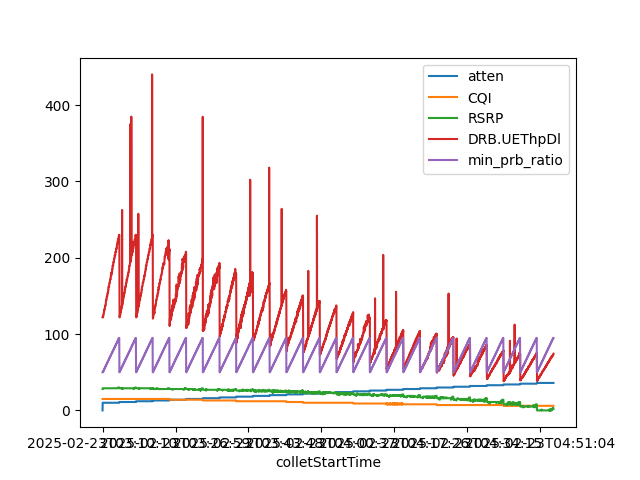

In [20]:
# get a general idea of what the relevant data points look like
ue1_df.plot(x='timestamp', y=['atten', 'CQI', 'RSRP', 'DRB.UEThpDl', 'min_prb_ratio'])

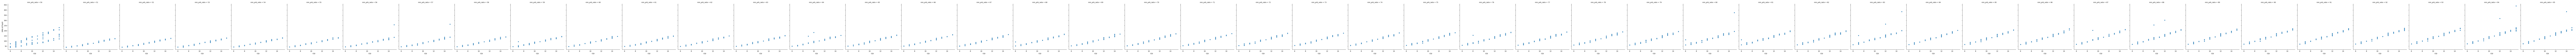

In [21]:
# Tput vs. CQI and min prb ratio
# note the transient values at the ratio switch points (95 -> 50 is the most egregious) 
sns.relplot(data=ue1_df, x='CQI', y='DRB.UEThpDl', col='min_prb_ratio')

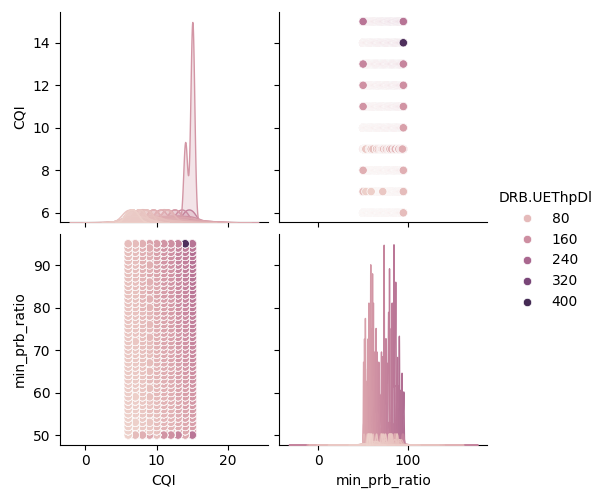

In [23]:
# another view
data = ue1_df[['CQI','DRB.UEThpDl', 'min_prb_ratio']]
sns.pairplot(data=data, hue='DRB.UEThpDl')
#sns.pairplot(data=data)

In [27]:
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
# print(f"device {device}")
device = 'cpu'

features = data[['CQI','DRB.UEThpDl']].values
targets = data[['min_prb_ratio']].values

# need some scaling, else loss/gradients explode
scaler_feat = StandardScaler()
scaler_targ = StandardScaler()
features_scaled = scaler_feat.fit_transform(features)
targets_scaled = scaler_targ.fit_transform(targets)

# create tensors; send to gpu
X = torch.tensor(features_scaled, device=device).float()
y = torch.tensor(targets_scaled, device=device).float()


In [29]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(2, 1)  # two input feature, one output feature

    def forward(self, x):
        return self.linear(x)


model = LinearRegressionModel().to(device)
X.to(device)
y.to(device)
criterion = torch.nn.MSELoss() # Mean Squared Error
optimizer = torch.optim.SGD(model.parameters(), lr=.05)

# 4. Train the model
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    # Forward pass
    y_predicted = model(X)
    loss = criterion(y_predicted, y)
    # Backward and optimize
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/500], Loss: 1.8139
Epoch [101/500], Loss: 0.3737
Epoch [201/500], Loss: 0.2967
Epoch [301/500], Loss: 0.2906
Epoch [401/500], Loss: 0.2901


In [30]:
# generate some predictions across a range of input vals
# and unscale
model.eval()
with torch.no_grad():
    test_input = np.zeros((10 * 16, 2))
    for ii in range(10):
        test_input[ii * 16:ii * 16 + 16, 0] = ii + 6
        test_input[ii * 16:ii * 16 + 16, 1] = np.arange(50, 210, 10)
    test_input = torch.tensor(test_input, dtype=torch.float).to(device)
    # Transform the test input
    test_input_scaled = scaler_feat.transform(test_input.cpu().numpy())
    test_input_scaled = torch.tensor(test_input_scaled, dtype=torch.float, device=device)

    predicted_scaled = model(test_input_scaled)
    predicted = scaler_targ.inverse_transform(predicted_scaled.cpu().numpy())  # Inverse transform
    print(f'Predicted value for input {np.concatenate((test_input.cpu().numpy(), predicted), axis=1)}')


Predicted value for input [[  6.         50.         71.2718   ]
 [  6.         60.         76.15654  ]
 [  6.         70.         81.041275 ]
 [  6.         80.         85.92601  ]
 [  6.         90.         90.810745 ]
 [  6.        100.         95.69549  ]
 [  6.        110.        100.58022  ]
 [  6.        120.        105.464966 ]
 [  6.        130.        110.3497   ]
 [  6.        140.        115.234436 ]
 [  6.        150.        120.11918  ]
 [  6.        160.        125.003914 ]
 [  6.        170.        129.88866  ]
 [  6.        180.        134.77338  ]
 [  6.        190.        139.65813  ]
 [  6.        200.        144.54286  ]
 [  7.         50.         64.7575   ]
 [  7.         60.         69.642235 ]
 [  7.         70.         74.52697  ]
 [  7.         80.         79.411705 ]
 [  7.         90.         84.29645  ]
 [  7.        100.         89.18118  ]
 [  7.        110.         94.06592  ]
 [  7.        120.         98.95066  ]
 [  7.        130.        103.835396 ]


Learned Hyperplane:
y = -1.51*x1 + 1.73*x2 + 0.00


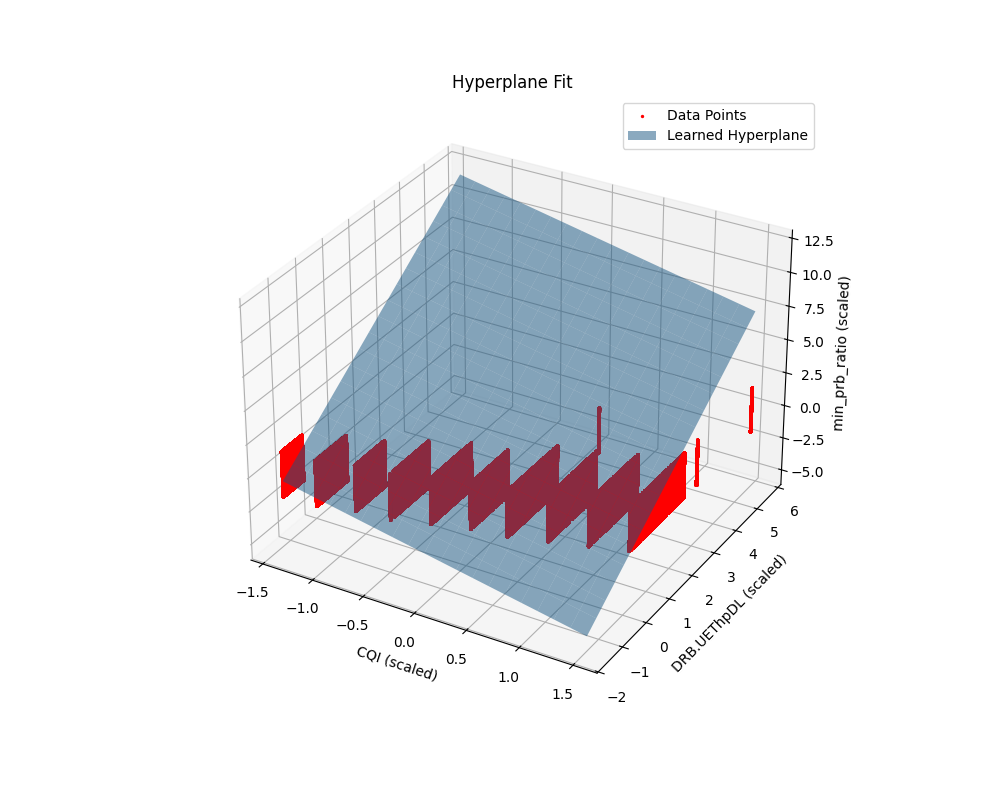

In [31]:
# look at the poor hyperplane fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
# Get the learned parameters
learned_weights = model.linear.weight.data.cpu().numpy()
learned_bias = model.linear.bias.data.cpu().numpy()

# Print the learned hyperplane equation
print("\nLearned Hyperplane:")
print(f"y = {learned_weights[0][0]:.2f}*x1 + {learned_weights[0][1]:.2f}*x2 + {learned_bias[0]:.2f}")

# Plot the data and the learned hyperplane
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points

ax.scatter(features_scaled[::5,0], features_scaled[::5,1], targets_scaled, c='r', marker='o', label='Data Points', s=2)

# Create a meshgrid for the hyperplane
x1_range = np.linspace(features_scaled[::5,0].min(), features_scaled[::5,0].max(), 20)
x2_range = np.linspace(features_scaled[::5,1].min(), features_scaled[::5,1].max(), 20)
X1, X2 = np.meshgrid(x1_range, x2_range)
Y_predicted_scaled = learned_weights[0][0] * X1 + learned_weights[0][1] * X2 + learned_bias[0]

# Plot the learned hyperplane
ax.plot_surface(X1, X2, Y_predicted_scaled, alpha=0.5, label='Learned Hyperplane')

# Set labels and title
ax.set_xlabel('CQI (scaled)')
ax.set_ylabel('DRB.UEThpDL (scaled)')
ax.set_zlabel('min_prb_ratio (scaled)')
ax.set_title('Hyperplane Fit')
ax.legend()

# Show the plot
plt.show()